In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.HEP.NEWPHYSICS/master/init.py
import init; init.init(force_download=False);

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from progressbar import progressbar as pbar
from local.lib import histos2d as h2d
from scipy import stats
from scipy.optimize import minimize
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Asymptotic formulae for likelihood-based tests of new physics

https://arxiv.org/abs/1007.1727

Section 2 describes how to build a histogram $\mathbf{n}=(n_1,...,n_N)$ from measuring a variable $x$ which is composed of a background and signal component. Each component distribution is predicted by some theory. A parameter $\mu \in [0,1]$ represents the degree of presence of signal ($\mu=0 \rightarrow$ only background, $\mu=1 \rightarrow$ signal + background).

We assume we make the process of bulding histograms many times and, thus, we have a distribution of histograms. The expected value of the unmber of measurements contained in bin $n_i$ can be written as:

$$\begin{equation*}
\mathbb{E}[n_i] = \mu s_i + b_i
\end{equation*}
\tag{1}
$$

and the mean number of entries of signal and background are:


$$\begin{equation*}
s_i = s_\text{tot}\int_{\text{bin }i} f_s(x;\boldsymbol{\theta}_s)dx\\
b_i = b_\text{tot}\int_{\text{bin }i} f_b(x;\boldsymbol{\theta}_b)dx
\end{equation*}
\tag{2}
$$

where

- $s_\text{tot}, b_\text{tot} \in [0,1]$ and $s_\text{tot}+b_\text{tot}=1$ is the porcentage of measurements coming from the signal and from the background respectively.
- $f_s(x;\boldsymbol{\theta}_s)$ and $f_b(x;\boldsymbol{\theta}_b)$ are the $pdf$'s for variable $x$ as coming from signal or background

finally, the distribution of each bin is given by a Poisson variable


$$\begin{equation*}
n_i \sim \text{Poisson}(\lambda_i) \;\;\; \text{ with } \lambda_i=\mu s_i + b_i\\
P(n_i; \mu, \boldsymbol{\theta}_s, \boldsymbol{\theta}_b, s_\text{tot}, b_\text{tot}) = P(n_i; \mu, \boldsymbol{\theta}, s_\text{tot} ) = \frac{\lambda_i^{n_i}}{n_i!}e^{-\lambda_i} = \frac{(\mu s_i + b_i)^{n_i}}{n_i!}e^{-\mu s_i + b_i}
\end{equation*}
\tag{3}
$$

with $\boldsymbol{\theta} = (\boldsymbol{\theta}_s, \boldsymbol{\theta}_b, b_\text{tot})$, assuming $s_\text{tot}$ is fixed given by the theory and focusing on $\mu$.

observe that for any random variable $Z \sim \text{Poisson}(\lambda)$ its expected value $\mathbb{E}[Z]=\lambda$ (see [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) and, since the random variable associated with each bin $n_i\sim \text{Poisson}(\lambda_i)$, then $\mathbb{E}[n_i] = \lambda_i = \mu s_i + b_i$

### background and signal distributions

In this notebook, we **assume** background and signal distributions are the following

- $b \sim \text{exp}(t)$ with pdf $f_b(x;\boldsymbol{\theta}_b)$ and   $\boldsymbol{\theta}_b=(t)\;\;\;\;$ we use $t$ instead of $\lambda$ as customary for the Exponential distribuion for convinience in Python code
- $s \sim \mathcal{N}(\mu_s, \sigma_s)$ with pdf $f_s(x;\boldsymbol{\theta}_s)$ and $\boldsymbol{\theta}_s=(\mu_s, \sigma_s)$

Also, a specification of $N$ bins is given in `bin_edges` $\in \mathbb{R}^{N+1}$


### log likelihood

for the moment we try to estimate $\mu$ assuming all the rest of parameters $ (\boldsymbol{\theta}, s_\text{tot}) $ are fixed.

Given **one** observed histogram, the log likelihood of a given $\mu$ is given by:


$$\mathcal{L}(\mu) = \log \prod_{i=1}^N \frac{(\mu s_i + b_i)^{\overline{n_i}}}{\overline{n_i}!}e^{-\mu s_i + b_i} =  \sum_{i=1}^N \overline{n_i} \log  (\mu s_i + b_i) - \log (\overline{n_i}!)-\mu s_i - b_i$$

where $\overline{n_i}$ is the observed count in bin $i$, and we want:


$$\text{MLE}(\mu) = \underset{\mu}{\text{arg max}} \;\;\mathcal{L}(\mu) $$

In [2]:
n_bins = 20
bin_edges = np.r_[list(np.linspace(0,180,n_bins))+[np.inf]]
bin_edges

array([  0.        ,   9.47368421,  18.94736842,  28.42105263,
        37.89473684,  47.36842105,  56.84210526,  66.31578947,
        75.78947368,  85.26315789,  94.73684211, 104.21052632,
       113.68421053, 123.15789474, 132.63157895, 142.10526316,
       151.57894737, 161.05263158, 170.52631579, 180.        ,
                inf])

In [85]:
class BShist_distribution:
    
    def __init__(self, t, mu_s, sigma_s, mu, stot, btot, bin_edges, use_gaussian_appoximation=False):
        # render all params positive
        t, mu_s, sigma_s, mu, stot, btot = np.abs([t, mu_s, sigma_s, mu, stot, btot])
        stot,btot = int(stot), int(btot)
        self.t, self.mu_s, self.sigma_s, self.mu, self.stot, self.btot = t, mu_s, sigma_s, mu, stot, btot
        self.bin_edges = bin_edges
        self.n_bins = len(bin_edges)-1
        self.params = {'stot': self.stot, 'btot': self.btot, 't': self.t, 'mu_s': self.mu_s, 'sigma_s': self.sigma_s, "mu": self.mu}
        
        # base continuous distributions
        self.b = stats.expon(scale=1/t)
        self.s = stats.norm(loc=mu_s, scale=sigma_s)            
        
        # compute distribution for each bin
        self.si = self.stot*pd.Series([self.s.cdf(i) for i in self.bin_edges]).diff().dropna().values
        self.bi = self.btot*pd.Series([self.b.cdf(i) for i in self.bin_edges]).diff().dropna().values
        if len(self.si)!=len(self.bi):
            print ("ERROR!!", self.t, self.mu_s, self.sigma_s, mu, btot, stot)
        self.ni = self.mu * self.si + self.bi  
            
        if not use_gaussian_appoximation:
            self.bins_distributions = [stats.poisson(mu=self.ni[i]).pmf for i in range(len(self.ni))]       
        else:
            self.bins_distributions = [stats.norm(loc=self.ni[i], scale=np.sqrt(self.ni[i])+1e-50).pdf for i in range(len(self.ni))]        
        
        
    def rvs(self, n_samples):
        """
        samples the histograms distribution: n = s + b
        """
        nl, sl, bl = [], [], []
        be = self.bin_edges
        iterator = pbar(range(n_samples)) if n_samples>1 else range(n_samples)
        for _ in iterator:
            sample_s = self.s.rvs(self.stot)
            sample_b = self.b.rvs(self.btot)
            ks = np.r_[[np.sum((sample_s>be[i])&(sample_s<be[i+1])) for i in range(0,len(be)-1)]]
            kb = np.r_[[np.sum((sample_b>be[i])&(sample_b<be[i+1])) for i in range(0,len(be)-1)]]
            nl.append(self.mu*ks+kb)
            sl.append(ks)
            bl.append(kb)
        nl = pd.DataFrame(np.r_[nl]); nl.index.name ="sample_nb"; nl.columns.name = "bin_nb"
        sl = pd.DataFrame(np.r_[sl]); sl.index.name ="sample_nb"; sl.columns.name = "bin_nb"
        bl = pd.DataFrame(np.r_[bl]); bl.index.name ="sample_nb"; bl.columns.name = "bin_nb"
        return nl,sl,bl
    
    def log_probability(self, observed_histogram):
        return np.sum([np.log(1e-100+self.bins_distributions[i](observed_histogram[i])) for i in range(len(observed_histogram))])
      
    def probability(self, observed_histogram):
        return np.product([self.bins_distributions[i](observed_histogram[i]) for i in range(len(observed_histogram))])     

    def plot_theoretical_distribution(self, label_prefix="", **kwargs):
        plt.plot(self.bin_edges[:-1], self.ni, label=label_prefix+"theoretical distribution", **kwargs)
    
    def plot_histogram(self, histogram):
        be = (self.bin_edges[1:]+self.bin_edges[:-1])/2
        bw = self.bin_edges[0]-self.bin_edges[1]
        plt.bar(self.bin_edges[:-1], histogram, width=bw*.9, alpha=.5, label="a sampled histogram")        
        self.plot_theoretical_distribution(color="black")
        plt.grid(); 
        plt.legend();
        plt.title("logprob of histogram %.3f"%self.log_probability(histogram))
    
    def clone(self, t=None, mu_s=None, sigma_s=None, mu=None, stot=None, btot=None):
        t       = t or self.t
        mu_s    = mu_s or self.mu_s
        sigma_s = sigma_s or self.sigma_s
        mu      = mu or self.mu
        stot    = stot or self.stot
        btot    = btot or self.btot
        return self.__class__(t, mu_s, sigma_s, mu, stot, btot, self.bin_edges)        
    
    def plot_logprob_param_sensitivity(self, observed_histogram):
        param_names = list(self.params.keys())

        interval_size = .8

        plt.figure(figsize=(5*len(param_names), 3))
        for k, param in enumerate(param_names):
            plt.subplot(1,len(param_names), k+1)
            param_value = eval('self.%s'%param)
            param_range = np.linspace(param_value*(1-interval_size/2), param_value*(1+interval_size/2), 100)
            probs = [bh.clone(**{param: i}).log_probability(observed_histogram) for i in param_range]
            plt.plot(param_range, probs)
            plt.grid();
            plt.axvline(param_value, color="red", label="true param")
            plt.legend();
            plt.title(param)
            if k==0:
                plt.ylabel("log probability")
        plt.show()    

    def MLE(self, fixed_params, observed_histogram, verbose=False):
        """
        computes MLE for all params except the ones listed in fixed_params
        """
        fixed_params = {k:self.params[k] for k in fixed_params}
        params_names = list(self.params.keys())


        def log_likelihood(varparams_values):
            assert len(varparams_values)+len(fixed_params)==len(params_names), "mismatched params"
            params = {**fixed_params, **{k:v for k,v in zip([i for i in params_names if not i in fixed_params.keys()], varparams_values)}}
            r = -BShist_distribution(**params, bin_edges=bin_edges).log_probability(observed_histogram)
            # print (varparams_values, r, params)
            return np.r_[r]


        x0 = np.random.random(len(params_names)-len(fixed_params))
        x0 = np.r_[[eval("bh.%s"%i) for i in params_names if not i in fixed_params.keys()]]
        x0 = x0*(.1+np.random.random()*20)

        r = minimize(log_likelihood, method="Nelder-Mead", x0=x0)
        optimized_params = {k:v for k,v in zip([i for i in params_names if not i in fixed_params.keys()], r.x)}
    
        if verbose:
            print ("fixed params    ", fixed_params)
            print ("init params     ", {k:v for k,v in zip([i for i in params_names if not i in fixed_params.keys()], x0)})
            print ("optimized params", optimized_params)
            print ("expected params ", {i:bh.params[i] for i in optimized_params.keys()})
            print ()
            print (r)
        return optimized_params, self.clone(**{**fixed_params, **optimized_params})        
        

# an experiment set with certain parameter values

In [4]:
bh = BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=100, btot=1000, bin_edges=bin_edges)

### some sampled histograms

100% (3 of 3) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


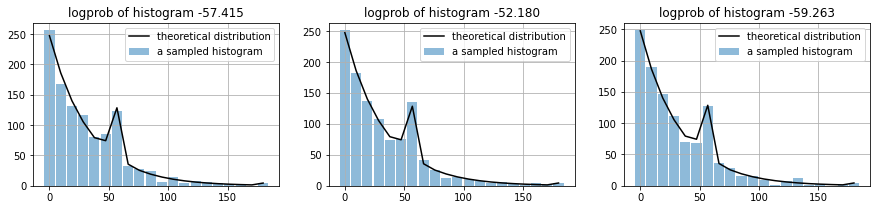

In [5]:
sn,ss,sb = bh.rvs(3)
plt.figure(figsize=(5*len(sn),3))
for i in range(len(sn)):
    plt.subplot(1,len(sn),i+1)
    observed_histogram = sn.values[i]
    bh.plot_histogram(observed_histogram)

### logprog param sensitivity for a histogram from the SAME distribution

how logprob of a sampled histogram changes as the params change

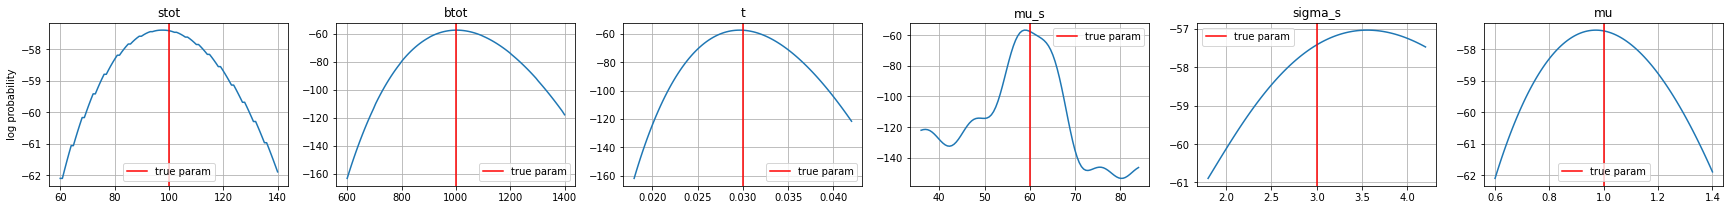

In [6]:
observed_histogram = sn.values[0]
bh.plot_logprob_param_sensitivity(observed_histogram)

### logprog param sensitivity for a histogram from a DIFFERENT distribution

slightly change one param for the new distribution

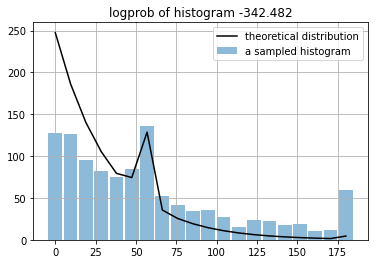

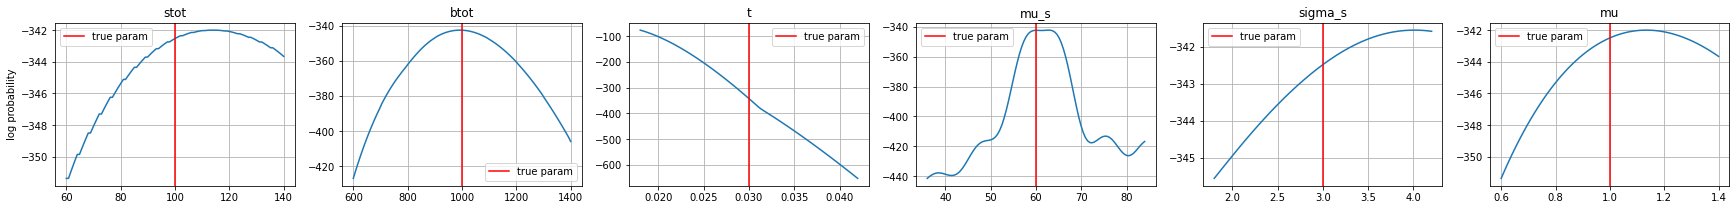

In [7]:
observed_histogram2 = bh.clone(t=bh.t*.5).rvs(1)[0].values[0]
bh.plot_histogram(observed_histogram2)
bh.plot_logprob_param_sensitivity(observed_histogram2)

for a slight change on another parameter

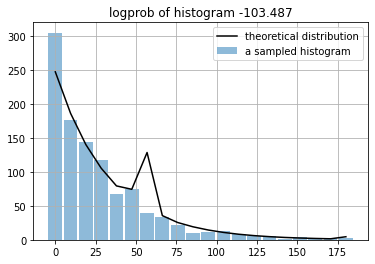

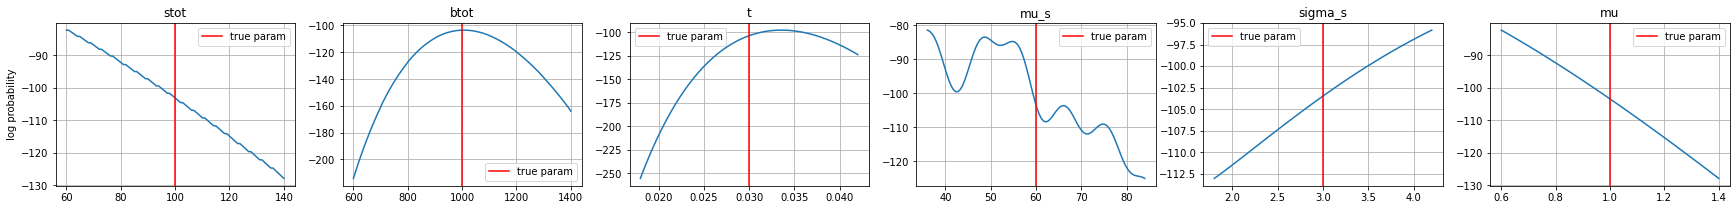

In [8]:
observed_histogram2 = bh.clone(mu_s=1).rvs(1)[0].values[0]
bh.plot_histogram(observed_histogram2)
bh.plot_logprob_param_sensitivity(observed_histogram2)

# Maximum likelihood estimation

### sample a `observed_histogram`

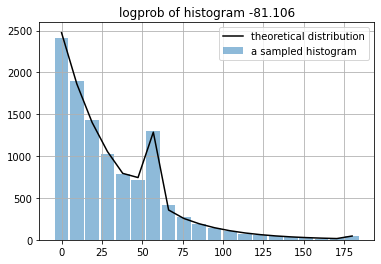

In [10]:
bh = BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)
sn,ss,sb = bh.rvs(1)
observed_histogram = sn.values[0]
bh.plot_histogram(observed_histogram)

### MLE estimate $\mu$ 

very stable

In [70]:
bh = BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)
optimized_params, optimized_bh = bh.MLE(fixed_params = ["stot", "btot", "mu_s", "sigma_s", "t"], observed_histogram=observed_histogram, verbose=True)

fixed params     {'stot': 1000, 'btot': 10000, 'mu_s': 60.0, 'sigma_s': 3.0, 't': 0.03}
init params      {'mu': 5.3446633164938335}
optimized params {'mu': 1.0062346475864845}
expected params  {'mu': 1.0}

 final_simplex: (array([[1.00623465],
       [1.00616941]]), array([81.09474127, 81.0947422 ]))
           fun: 81.094741271232
       message: 'Optimization terminated successfully.'
          nfev: 43
           nit: 21
        status: 0
       success: True
             x: array([1.00623465])


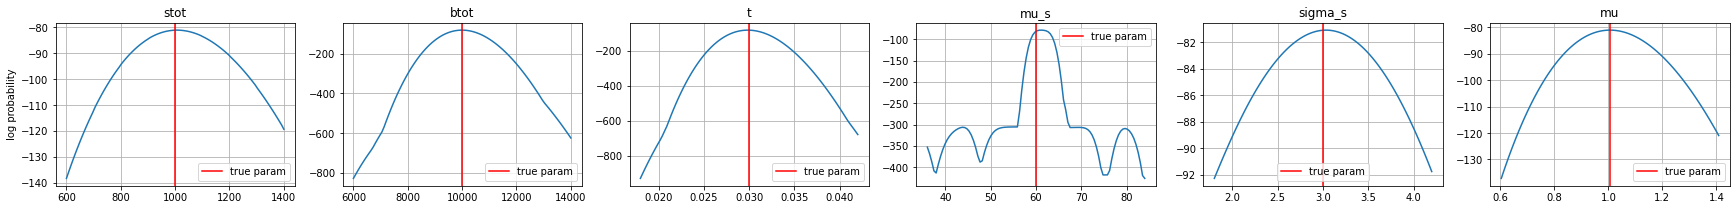

In [71]:
optimized_bh.plot_logprob_param_sensitivity(observed_histogram)

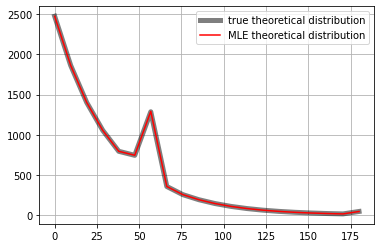

In [72]:
bh.plot_theoretical_distribution(label_prefix="true ", color="black", alpha=.5, lw=5)
optimized_bh.plot_theoretical_distribution(label_prefix="MLE ", color="red")
plt.grid(); plt.legend();

### MLE estimate $\mu$ AND $t$

somewhat unstable, even if optimization ends successfully estimated params are sometimes not correct

In [35]:
bh = BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)
optimized_params, optimized_bh = bh.MLE(fixed_params = ["stot", "btot", "mu_s", "sigma_s"], observed_histogram=observed_histogram, verbose=True)

fixed params     {'stot': 1000, 'btot': 10000, 'mu_s': 60.0, 'sigma_s': 3.0}
init params      {'t': 0.12126362446676521, 'mu': 4.042120815558841}
optimized params {'t': 0.14472697747844757, 'mu': 4.794376567416828}
expected params  {'t': 0.03, 'mu': 1.0}

 final_simplex: (array([[0.14472698, 4.79437657],
       [0.14472585, 4.79431906],
       [0.14472458, 4.79438365]]), array([2081.21977321, 2081.21977324, 2081.21977335]))
           fun: 2081.219773208207
       message: 'Optimization terminated successfully.'
          nfev: 67
           nit: 35
        status: 0
       success: True
             x: array([0.14472698, 4.79437657])


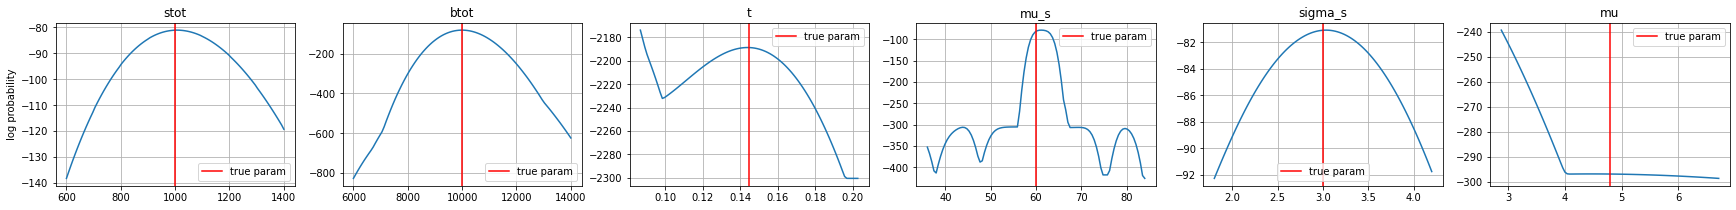

In [36]:
optimized_bh.plot_logprob_param_sensitivity(observed_histogram)

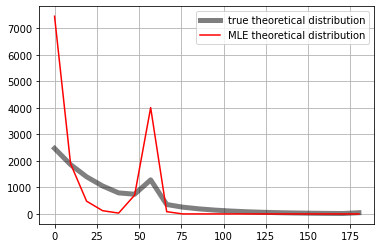

In [37]:
bh.plot_theoretical_distribution(label_prefix="true ", color="black", alpha=.5, lw=5)
optimized_bh.plot_theoretical_distribution(label_prefix="MLE ", color="red")
plt.grid(); plt.legend();

### MLE estimate $\mathcal{L}(\mu, \hat{\hat{\mathbf{\theta}}})\;\;$,  for a fixed $\mu$ (the true one), and optimizing for $t$, $b_{tot}$, $\mu_s$, $\sigma_s$

optimization **moves very little** from the initial params, probably due to flat regions in params space, mostly on $\mu_s$


In [86]:
bh = BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)
optimized_params, optimized_bh = bh.MLE(fixed_params = ["stot", "mu"], observed_histogram=observed_histogram, verbose=True)

fixed params     {'stot': 1000, 'mu': 1.0}
init params      {'btot': 149635.1620708767, 't': 0.44890548621263004, 'mu_s': 897.81097242526, 'sigma_s': 44.89054862126301}
optimized params {'btot': 146877.2570208158, 't': 0.45787388076568125, 'mu_s': 915.3685734155556, 'sigma_s': 45.12802301088141}
expected params  {'btot': 10000, 't': 0.03, 'mu_s': 60.0, 'sigma_s': 3.0}

 final_simplex: (array([[1.46877257e+05, 4.57873881e-01, 9.15368573e+02, 4.51280230e+01],
       [1.46877257e+05, 4.57873881e-01, 9.15368572e+02, 4.51280231e+01],
       [1.46877257e+05, 4.57873881e-01, 9.15368574e+02, 4.51280229e+01],
       [1.46877257e+05, 4.57873881e-01, 9.15368572e+02, 4.51280230e+01],
       [1.46877257e+05, 4.57873881e-01, 9.15368573e+02, 4.51280230e+01]]), array([4379.60388236, 4379.60388236, 4379.60388236, 4379.60388236,
       4379.60388236]))
           fun: 4379.603882357355
       message: 'Optimization terminated successfully.'
          nfev: 234
           nit: 108
        status: 0
     

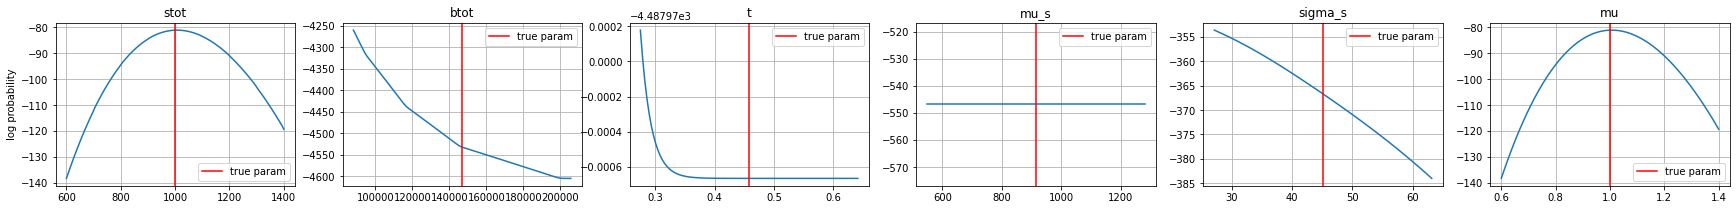

In [87]:
optimized_bh.plot_logprob_param_sensitivity(observed_histogram)

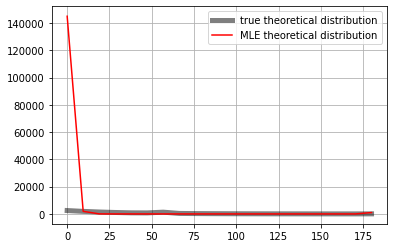

In [88]:
bh.plot_theoretical_distribution(label_prefix="true ", color="black", alpha=.5, lw=5)
optimized_bh.plot_theoretical_distribution(label_prefix="MLE ", color="red")
plt.grid(); plt.legend();

### MLE estimate $\mathcal{L}(\hat{\mu}, \hat{\mathbf{\theta}})\;\;$ optimizing for $\mu$, $t$, $b_{tot}$, $\mu_s$, $\sigma_s$

similar to above

In [89]:
bh = BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)
optimized_params, optimized_bh = bh.MLE(fixed_params = ["stot"], observed_histogram=observed_histogram, verbose=True)

fixed params     {'stot': 1000}
init params      {'btot': 178321.29046321864, 't': 0.5349638713896558, 'mu_s': 1069.9277427793118, 'sigma_s': 53.49638713896559, 'mu': 17.832129046321864}
optimized params {'btot': 185957.13405165705, 't': 0.4830729003169886, 'mu_s': 1097.3330196039044, 'sigma_s': 54.74171194261381, 'mu': 18.18067266782943}
expected params  {'btot': 10000, 't': 0.03, 'mu_s': 60.0, 'sigma_s': 3.0, 'mu': 1.0}

 final_simplex: (array([[1.85957134e+05, 4.83072900e-01, 1.09733302e+03, 5.47417119e+01,
        1.81806727e+01],
       [1.85957134e+05, 4.83072900e-01, 1.09733302e+03, 5.47417119e+01,
        1.81806727e+01],
       [1.85957134e+05, 4.83072900e-01, 1.09733302e+03, 5.47417119e+01,
        1.81806727e+01],
       [1.85957134e+05, 4.83072900e-01, 1.09733302e+03, 5.47417119e+01,
        1.81806727e+01],
       [1.85957134e+05, 4.83072900e-01, 1.09733302e+03, 5.47417119e+01,
        1.81806727e+01],
       [1.85957134e+05, 4.83072900e-01, 1.09733302e+03, 5.47417120e+01,

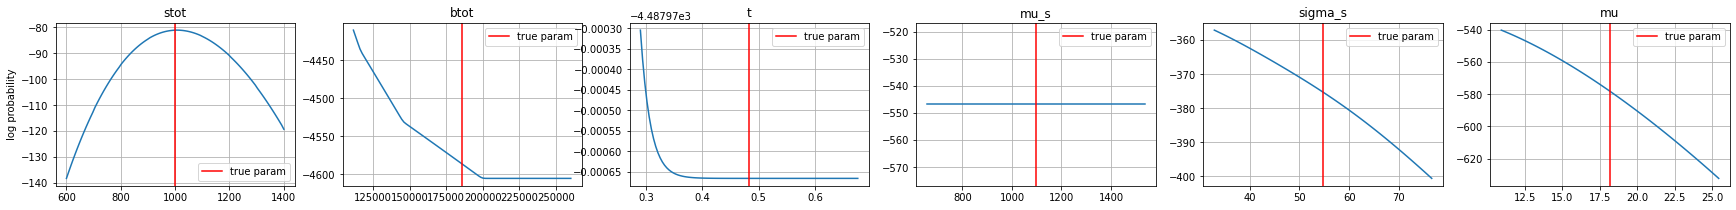

In [90]:
optimized_bh.plot_logprob_param_sensitivity(observed_histogram)

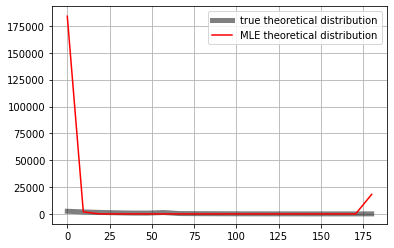

In [91]:
bh.plot_theoretical_distribution(label_prefix="true ", color="black", alpha=.5, lw=5)
optimized_bh.plot_theoretical_distribution(label_prefix="MLE ", color="red")
plt.grid(); plt.legend();

### MLE estimate  for a fixed $\mu_s$ (the true ones), and optimizing for $t$, $\mu$, $b_{tot}$, $s_\mu$, $s_\sigma$

optimization still unstable but not so much

In [92]:
bh = BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)
optimized_params, optimized_bh = bh.MLE(fixed_params = ["stot", "mu_s"], observed_histogram=observed_histogram, verbose=True)

fixed params     {'stot': 1000, 'mu_s': 60.0}
init params      {'btot': 192679.46489060958, 't': 0.5780383946718287, 'sigma_s': 57.80383946718287, 'mu': 19.267946489060957}
optimized params {'btot': 335955.6407830629, 't': 0.5595486043184865, 'sigma_s': 37.66975683866792, 'mu': 4.731580758874627}
expected params  {'btot': 10000, 't': 0.03, 'sigma_s': 3.0, 'mu': 1.0}

 final_simplex: (array([[3.35955641e+05, 5.59548604e-01, 3.76697568e+01, 4.73158076e+00],
       [3.35955641e+05, 5.59548604e-01, 3.76697568e+01, 4.73158076e+00],
       [3.35955641e+05, 5.59548604e-01, 3.76697568e+01, 4.73158076e+00],
       [3.35955641e+05, 5.59548604e-01, 3.76697568e+01, 4.73158076e+00],
       [3.35955641e+05, 5.59548604e-01, 3.76697568e+01, 4.73158076e+00]]), array([1399.75138326, 1399.75138326, 1399.75138326, 1399.75138326,
       1399.75138326]))
           fun: 1399.7513832619932
       message: 'Optimization terminated successfully.'
          nfev: 350
           nit: 188
        status: 0
      

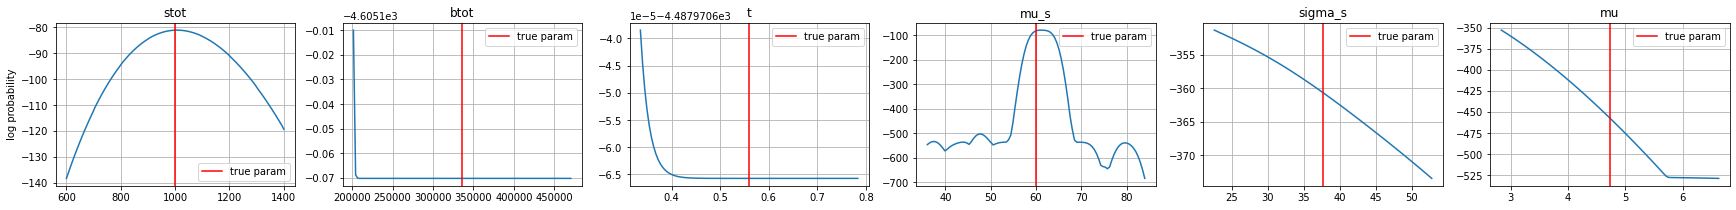

In [93]:
optimized_bh.plot_logprob_param_sensitivity(observed_histogram)

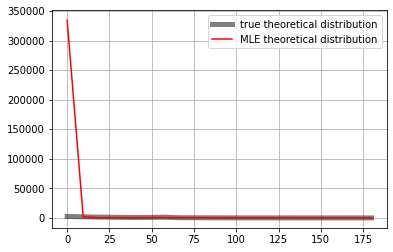

In [94]:
bh.plot_theoretical_distribution(label_prefix="true ", color="black", alpha=.5, lw=5)
optimized_bh.plot_theoretical_distribution(label_prefix="MLE ", color="red")
plt.grid(); plt.legend();

### MLE estimate  for a fixed $\mu_s$ (the true ones), and optimizing for $t$, $\mu$, $b_{tot}$, $s_\mu$, $s_\sigma$ using Gaussian aprox to Poisson

seems to work better ocassionally, at least partially, failing to estimate $\mu_s$ and $\sigma_s$ (too wide $\sigma_s$ equiv. to no signal)

In [115]:
bh = BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges, use_gaussian_appoximation=True)
optimized_params, optimized_bh = bh.MLE(fixed_params = ["stot", "mu_s"], observed_histogram=observed_histogram, verbose=True)

fixed params     {'stot': 1000, 'mu_s': 60.0}
init params      {'btot': 90581.75919405736, 't': 0.27174527758217204, 'sigma_s': 27.17452775821721, 'mu': 9.058175919405736}
optimized params {'btot': -9991.000141763547, 't': 0.03005302415769282, 'sigma_s': 43.71742652849895, 'mu': 0.19376488715229634}
expected params  {'btot': 10000, 't': 0.03, 'sigma_s': 3.0, 'mu': 1.0}

 final_simplex: (array([[-9.99100014e+03,  3.00530242e-02,  4.37174265e+01,
         1.93764887e-01],
       [-9.99100024e+03,  3.00530391e-02,  4.37174250e+01,
         1.93766390e-01],
       [-9.99100010e+03,  3.00530397e-02,  4.37174237e+01,
         1.93761786e-01],
       [-9.99100017e+03,  3.00530586e-02,  4.37174211e+01,
         1.93761294e-01],
       [-9.99100020e+03,  3.00529879e-02,  4.37174282e+01,
         1.93752922e-01]]), array([316.49103415, 316.49103415, 316.49103415, 316.49103415,
       316.49103416]))
           fun: 316.4910341450409
       message: 'Optimization terminated successfully.'
       

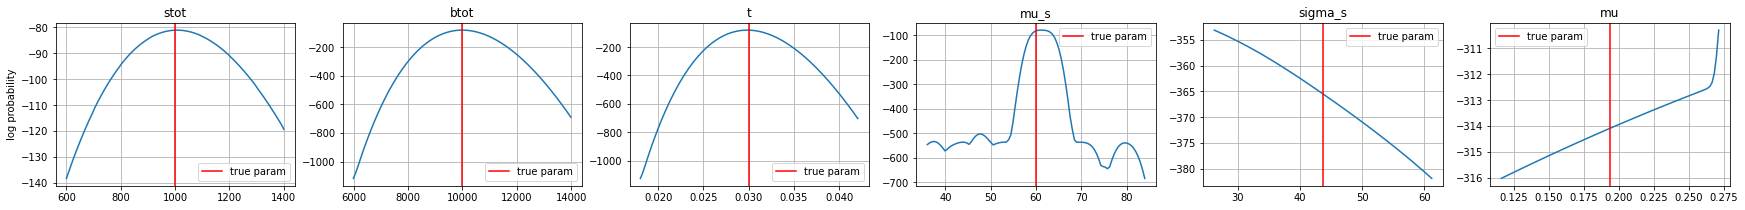

In [116]:
optimized_bh.plot_logprob_param_sensitivity(observed_histogram)

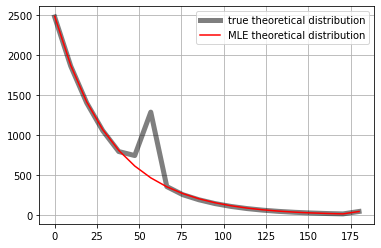

In [117]:
bh.plot_theoretical_distribution(label_prefix="true ", color="black", alpha=.5, lw=5)
optimized_bh.plot_theoretical_distribution(label_prefix="MLE ", color="red")
plt.grid(); plt.legend();